In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

LATENT_DIM = 512
IMG_CHANNELS = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
def mapping_network(latent_dim, layers=8):
    layers_list = []
    for _ in range(layers):
        layers_list.append(nn.Linear(latent_dim, latent_dim))
        layers_list.append(nn.ReLU())
    return nn.Sequential(*layers_list)


In [3]:
class AdaIN(nn.Module):
    def forward(self, content, style):
        mean = content.mean([2, 3], keepdim=True)
        std = content.std([2, 3], keepdim=True)
        normalized = (content - mean) / (std + 1e-8)
        scale, bias = style
        return scale * normalized + bias


In [4]:
class ProgressiveBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.upsample(x)
        x = torch.relu(self.conv2(x))
        return x


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.mapping = mapping_network(LATENT_DIM)
        self.fc = nn.Linear(LATENT_DIM, 4 * 4 * 128)
        self.block = ProgressiveBlock(128, 64)
        self.to_rgb = nn.Conv2d(64, IMG_CHANNELS, 1)

    def forward(self, z):
        w = self.mapping(z)
        x = self.fc(w)
        x = x.view(-1, 128, 4, 4)
        x = self.block(x)
        return torch.tanh(self.to_rgb(x))

generator = Generator().to(DEVICE)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(IMG_CHANNELS, 64, 3, padding=1)
        self.fc = nn.Linear(64 * 8 * 8, 1)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

discriminator = Discriminator().to(DEVICE)


In [7]:
def show_images(images, rows, cols):
    images = (images + 1) / 2
    fig, axs = plt.subplots(rows, cols, figsize=(8, 8))
    for i, ax in enumerate(axs.flatten()):
        img = images[i].detach().cpu().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis("off")
    plt.show()


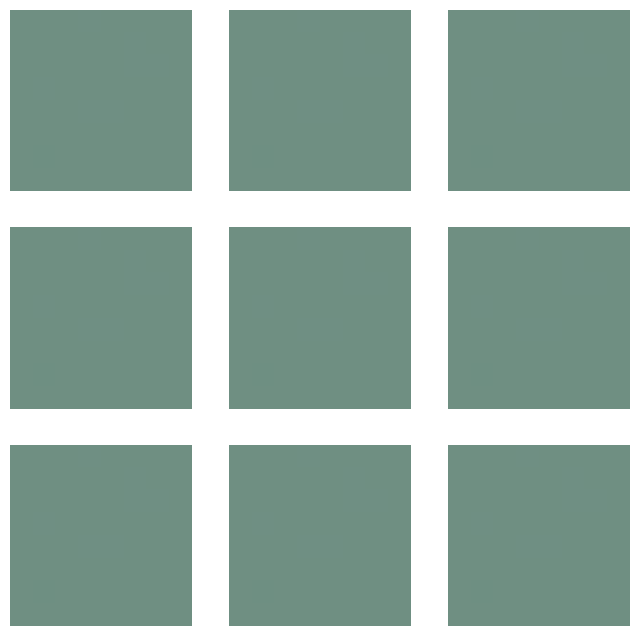

In [8]:
noise = torch.randn(9, LATENT_DIM).to(DEVICE)
fake_images = generator(noise)
show_images(fake_images, 3, 3)
